<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/Masterarbeit_EDA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aktuelle Version der EDA:
Die Struktur ist an die Gliederung des 2ten Materprojektes angepasst.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import modules

import io, os, sys, setuptools, tokenize
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from math import sqrt

In [3]:
# Größe der Plots festlegen
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [4]:
# Allgemeine Angaben
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

# tz, altitude, name = 'Europe/Berlin', 70, 'SanktAugustin'
# tus = pvlib.location.Location(latitude, longitude, tz, altitude, name)

In [5]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'

folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
folder_export = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

# Import der Vorhersagewerte:

In [6]:
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)
df_Vorhersage.set_index('Datetime', inplace=True)
df_Vorhersage.index = pd.to_datetime(df_Vorhersage.index)

# Import der Messwerte:

In [7]:
df_Messwerte = pd.read_csv(folder_import + name_Messwerte)
df_Messwerte.set_index('Datetime', inplace=True)
df_Messwerte.index = pd.to_datetime(df_Messwerte.index)

In [8]:
hour_bins = [3, 6, 9, 12, 15, 18, 21]  # Beispiel für mögliche Bins
hour_labels = ['03:00-06:00', '06:00-09:00', '09:00-12:00', '12:00-15:00', '15:00-18:00', '18:00-21:00']
df_Messwerte['Time_bins'] = pd.cut(df_Messwerte['Hour'], bins=hour_bins, labels=hour_labels, right=False)

In [9]:
df_Messwerte

,Observation_period,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI,UVI,UVA,UVB,erythem,Datum,...,Temp,DiffGreater2,SZA,time_sin,time_cos,date_sin,date_cos,Date,Hour,Time_bins
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-15 07:20:00,2022-06-15 07:20:00,566.244,463.071,566.244,463.0710,2.408378,4.686417,281.330695,0.060209,2022-06-15,...,27.258333,0,55.189579,0.938191,-0.346117,0.282051,-0.959399,2022-06-15,7,06:00-09:00
2022-06-15 07:22:00,2022-06-15 07:22:00,571.440,467.799,571.440,467.7990,2.408378,4.686417,281.330695,0.060209,2022-06-15,...,28.058333,0,54.874946,0.938191,-0.346117,0.282051,-0.959399,2022-06-15,7,06:00-09:00
2022-06-15 07:24:00,2022-06-15 07:24:00,576.618,472.512,576.618,472.5120,2.462381,4.793073,287.094062,0.061560,2022-06-15,...,28.616667,0,54.560533,0.935135,-0.354291,0.282051,-0.959399,2022-06-15,7,06:00-09:00
2022-06-15 07:26:00,2022-06-15 07:26:00,581.772,477.204,581.772,477.2040,2.479048,4.817792,288.902613,0.061976,2022-06-15,...,26.791667,0,54.246355,0.932008,-0.362438,0.282051,-0.959399,2022-06-15,7,06:00-09:00
2022-06-15 07:28:00,2022-06-15 07:28:00,586.905,481.881,586.905,481.8810,2.543531,4.953151,292.450776,0.063588,2022-06-15,...,28.600000,0,53.932431,0.928810,-0.370557,0.282051,-0.959399,2022-06-15,7,06:00-09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 05:48:00,2023-08-19 05:48:00,148.533,82.110,64.545,1.3872,0.306965,0.383479,77.133209,0.007674,2023-08-19,...,24.183333,0,78.036815,0.998630,0.052336,-0.739447,-0.673215,2023-08-19,5,03:00-06:00
2023-08-19 05:50:00,2023-08-19 05:50:00,153.717,85.974,79.956,1.8315,0.312439,0.401176,76.895074,0.007811,2023-08-19,...,24.375000,0,77.722566,0.999048,0.043619,-0.739447,-0.673215,2023-08-19,5,03:00-06:00
2023-08-19 05:52:00,2023-08-19 05:52:00,158.928,89.892,96.276,2.3115,0.314239,0.414659,75.176522,0.007856,2023-08-19,...,24.550000,0,77.408121,0.999391,0.034899,-0.739447,-0.673215,2023-08-19,5,03:00-06:00


In [10]:
df_Vorhersage

,aod469,aod550,gtco3,uvbed,uvbedcs,hcc,lcc,tcc,index_sigma,index_coimbra,index_stein,kc
Datetime,,,,,,,,,,,,
2022-06-01 00:00:00,0.261836,0.211588,0.008161,-5.551115e-16,5.551115e-16,0.000000,0.000000,0.504647,NaN,NaN,NaN,NaN
2022-06-01 01:00:00,0.272371,0.220283,0.008044,-5.551115e-16,5.551115e-16,0.000000,0.000000,0.681122,NaN,NaN,NaN,NaN
2022-06-01 02:00:00,0.237297,0.190401,0.007992,-5.551115e-16,5.551115e-16,0.124487,0.015687,0.414249,NaN,NaN,NaN,NaN
2022-06-01 03:00:00,0.195020,0.155880,0.007971,-5.551115e-16,5.551115e-16,0.071994,0.005310,0.076343,NaN,NaN,NaN,NaN
2022-06-01 04:00:00,0.164975,0.131777,0.007959,7.204596e-02,7.198133e-02,0.000000,0.001114,0.001785,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31 19:00:00,0.131174,0.109557,0.006663,5.551115e-16,5.551115e-16,1.000000,0.259121,1.000000,NaN,NaN,NaN,NaN
2023-07-31 20:00:00,0.126791,0.106162,0.006666,5.551115e-16,5.551115e-16,1.000000,0.473365,1.000000,NaN,NaN,NaN,NaN
2023-07-31 21:00:00,0.133466,0.111809,0.006700,5.551115e-16,5.551115e-16,0.999878,0.934537,1.000000,NaN,NaN,NaN,NaN


Allgemeine Informationen über die Vorhersagewerte und Messwerte:

In [11]:
print(df_Vorhersage.describe(),
df_Vorhersage.isna().sum())

             aod469        aod550         gtco3         uvbed       uvbedcs  \
count  10224.000000  10224.000000  10224.000000  1.022400e+04  1.022400e+04   
mean       0.193068      0.158245      0.006973  8.174907e-01  1.083072e+00   
std        0.144147      0.118452      0.000769  1.493487e+00  1.829005e+00   
min        0.021603      0.017586      0.004843 -5.551115e-16 -5.551115e-16   
25%        0.093358      0.076800      0.006484  0.000000e+00  0.000000e+00   
50%        0.149364      0.122642      0.006922  2.699899e-02  4.136721e-02   
75%        0.251221      0.205252      0.007391  9.022764e-01  1.384716e+00   
max        1.345396      1.122722      0.010138  7.965581e+00  7.983141e+00   

                hcc           lcc           tcc  index_sigma  index_coimbra  \
count  10224.000000  10224.000000  10224.000000  1496.000000    1496.000000   
mean       0.421584      0.375480      0.678987     0.025037       0.129958   
std        0.432544      0.412021      0.386534    

In [12]:
df_Messwerte.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,Clear_sky_GHI,Clear_sky_BHI,GHI,BHI,UVI,UVA,UVB,erythem,Messzeitpunkt,ghi,...,Glo_SPLite,Dir,Temp,DiffGreater2,SZA,time_sin,time_cos,date_sin,date_cos,Hour
count,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,...,96732.000000,96732.000000,96732.000000,96732.0,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000,96732.000000
mean,377.061337,282.300395,251.386888,124.643681,1.338613,2.544459,139.639724,0.033465,40434.271803,252.510388,...,257.418303,247.506891,16.667025,0.0,65.078640,0.117815,-0.582861,-0.201033,-0.157266,10.755303
std,269.566974,225.175070,241.517545,191.700616,1.672862,3.294458,131.377063,0.041822,13427.490251,249.417223,...,247.777974,323.597029,8.580352,0.0,17.196990,0.698899,0.397417,0.644754,0.720524,3.738893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12360.000000,0.000000,...,0.000000,0.000000,-7.800000,0.0,27.364001,-1.000000,-1.000000,-0.999999,-0.999979,3.000000
10%,3.841680,1.270800,1.523100,0.000000,0.037342,0.027824,11.036623,0.000934,22320.000000,12.741667,...,15.933333,1.500000,5.000000,0.0,38.247379,-0.892979,-0.987688,-0.970858,-0.980903,6.000000
25%,153.680250,91.590000,34.062450,0.010800,0.152989,0.177071,34.861718,0.003825,29520.000000,52.341667,...,57.400000,2.033333,10.575000,0.0,52.291669,-0.555570,-0.923880,-0.739447,-0.820442,8.000000
50%,335.148000,241.957500,184.911000,3.224550,0.596635,1.023754,96.608427,0.014916,40560.000000,165.425000,...,171.904167,17.191667,16.733333,0.0,68.543967,0.190809,-0.704015,-0.359539,-0.319954,11.000000
75%,599.277000,464.379750,397.279500,186.698250,1.903550,3.722198,208.437527,0.047589,51300.000000,384.635417,...,394.222917,524.991667,22.950000,0.0,78.515781,0.831470,-0.329691,0.304725,0.609062,14.000000
90%,786.397500,619.801200,643.371900,448.383900,3.947258,7.758169,354.311147,0.098681,58380.000000,667.404167,...,672.612500,805.990833,27.983333,0.0,85.855706,0.972370,0.034899,0.769042,0.908937,16.000000
max,931.527000,812.622000,931.527000,812.622000,8.542809,16.142099,647.706510,0.213570,68220.000000,1232.833333,...,1189.925000,1016.758333,54.320000,0.0,97.870012,1.000000,0.622515,0.999578,0.998669,18.000000


In [13]:
# Interquartile Range berechnen

Q1_UVI = df_Messwerte['UVI'].quantile(0.25)
Q2_UVI = df_Messwerte['UVI'].quantile(0.5)
Q3_UVI = df_Messwerte['UVI'].quantile(0.75)

IQR_UVI = Q3_UVI - Q1_UVI

print(f"25. Perzentil: {round(Q1_UVI, 3)}, 5. Perzentil: {round(Q2_UVI, 3)}, 75. Perzentil: {round(Q3_UVI, 3)}, IQR: {round(IQR_UVI, 3)}")


25. Perzentil: 0.153, 5. Perzentil: 0.597, 75. Perzentil: 1.904, IQR: 1.751


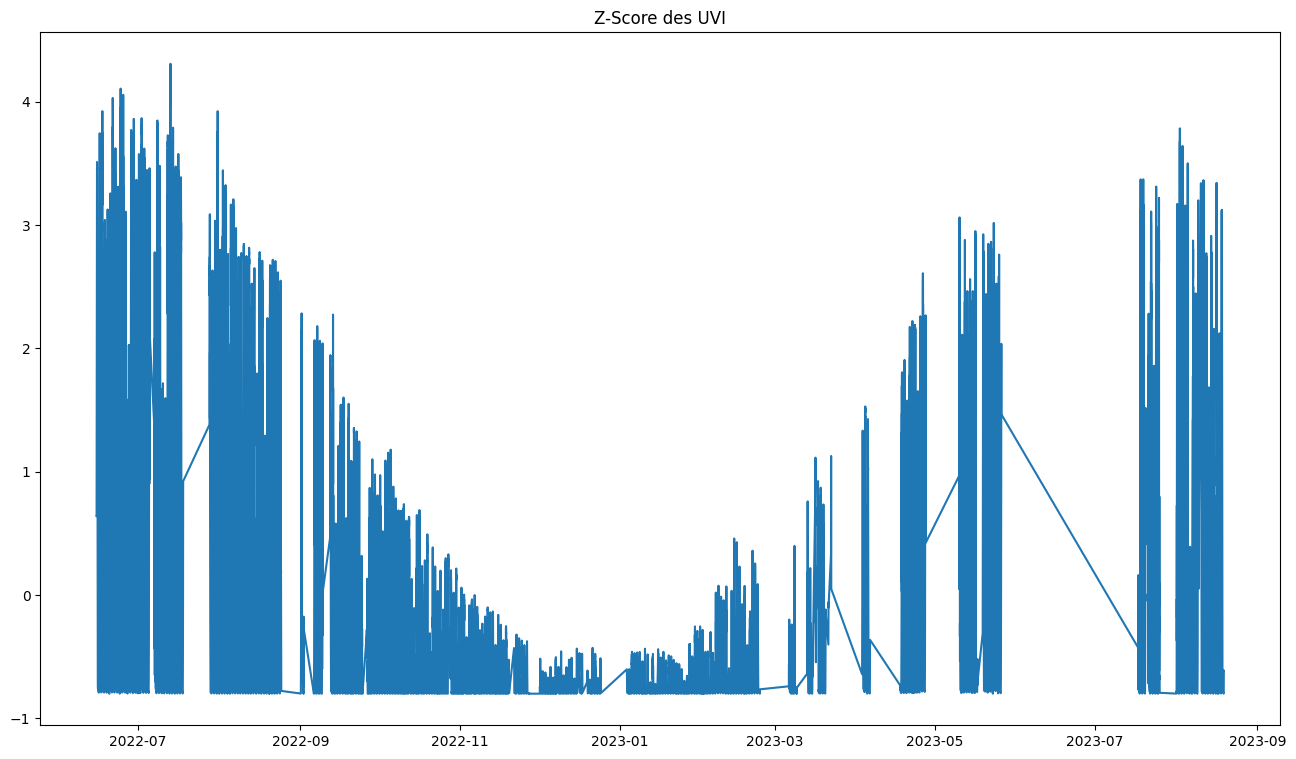

In [14]:
# Z-score über alle Messdaten berechnen
df_ZScore = pd.DataFrame()

mittelwert = df_Messwerte['UVI'].mean()
standardabweichung = df_Messwerte['UVI'].std()

df_ZScore['Z-Score'] = (df_Messwerte['UVI'] - mittelwert) / standardabweichung
plt.plot(df_ZScore)
plt.title('Z-Score des UVI')
plt.savefig('/content/drive/My Drive/Colab_Notebooks/plot_TSA/Z_Score_UVI.png')

# Qunatilspezifische Analyse des UVI:

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datum in datetime, falls nicht bereits erfolgt
df_Messwerte['Datum'] = pd.to_datetime(df_Messwerte['Datum'])

# Monat extrahieren
df_Messwerte['Monat'] = df_Messwerte['Datum'].dt.month

# Uhrzeit binär in Kategorien gruppiert (falls noch nicht vorhanden)
# z. B. 06:00–09:00 etc. scheint schon in 'Time_bins' zu sein

In [18]:
df_Messwerte, df_Vorhersage

(                      Observation_period  Clear_sky_GHI  Clear_sky_BHI  \
 Datetime                                                                 
 2022-06-15 07:20:00  2022-06-15 07:20:00        566.244        463.071   
 2022-06-15 07:22:00  2022-06-15 07:22:00        571.440        467.799   
 2022-06-15 07:24:00  2022-06-15 07:24:00        576.618        472.512   
 2022-06-15 07:26:00  2022-06-15 07:26:00        581.772        477.204   
 2022-06-15 07:28:00  2022-06-15 07:28:00        586.905        481.881   
 ...                                  ...            ...            ...   
 2023-08-19 05:48:00  2023-08-19 05:48:00        148.533         82.110   
 2023-08-19 05:50:00  2023-08-19 05:50:00        153.717         85.974   
 2023-08-19 05:52:00  2023-08-19 05:52:00        158.928         89.892   
 2023-08-19 05:54:00  2023-08-19 05:54:00        164.172         93.858   
 2023-08-19 05:56:00  2023-08-19 05:56:00        169.440         97.872   
 
                       

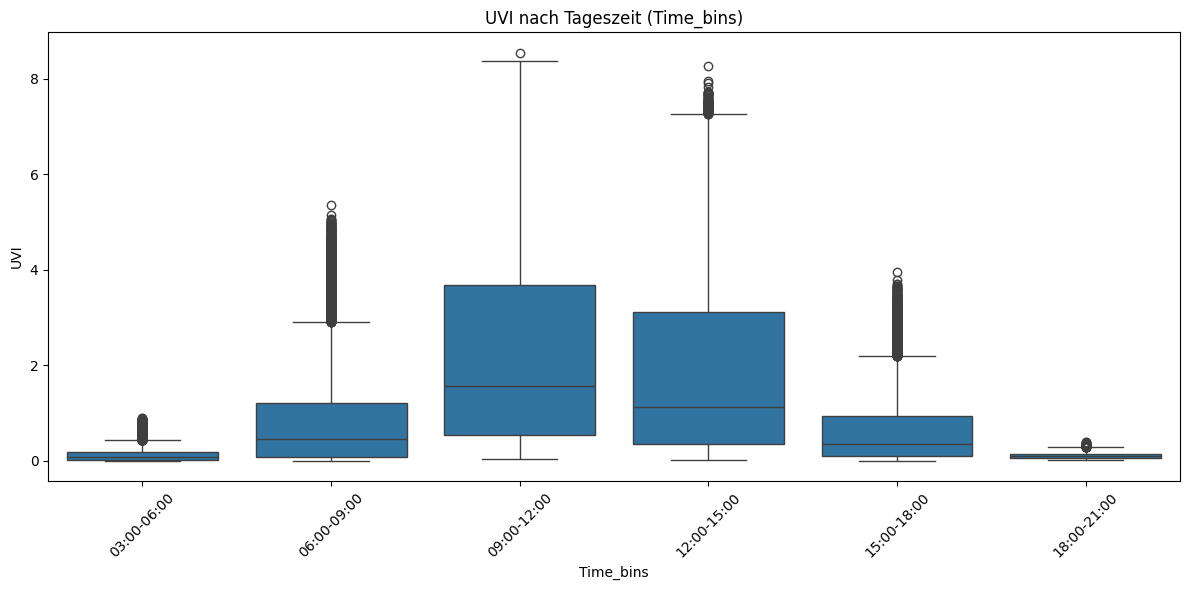

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_Messwerte, x='Time_bins', y='UVI')
plt.title('UVI nach Tageszeit (Time_bins)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

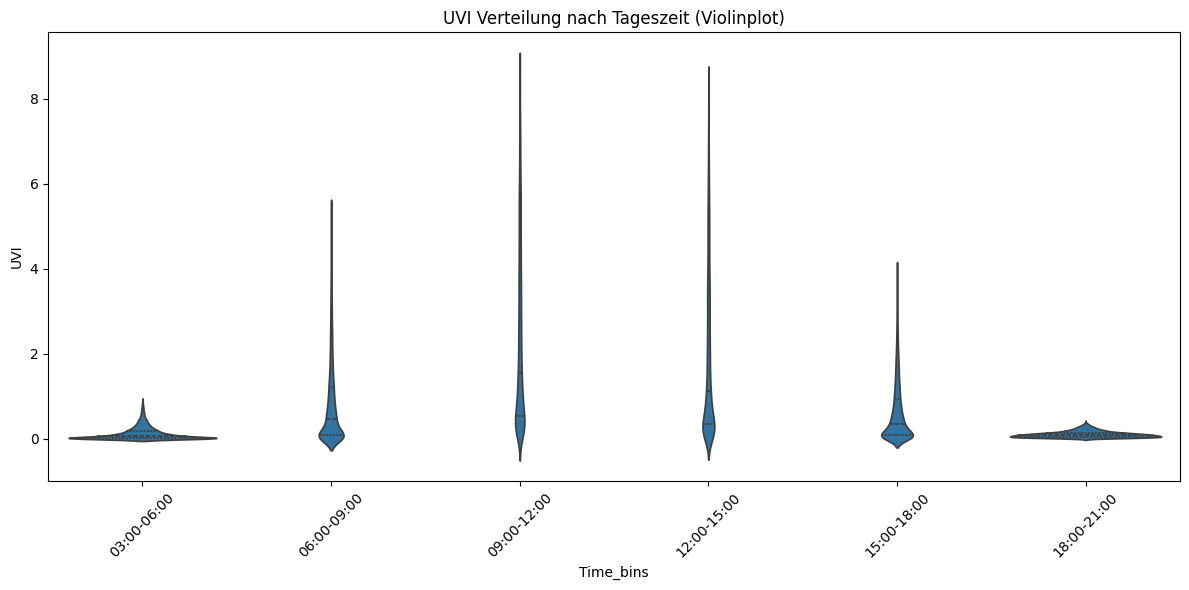

In [33]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_Messwerte, x='Time_bins', y='UVI', inner='quartile')
plt.title('UVI Verteilung nach Tageszeit (Violinplot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

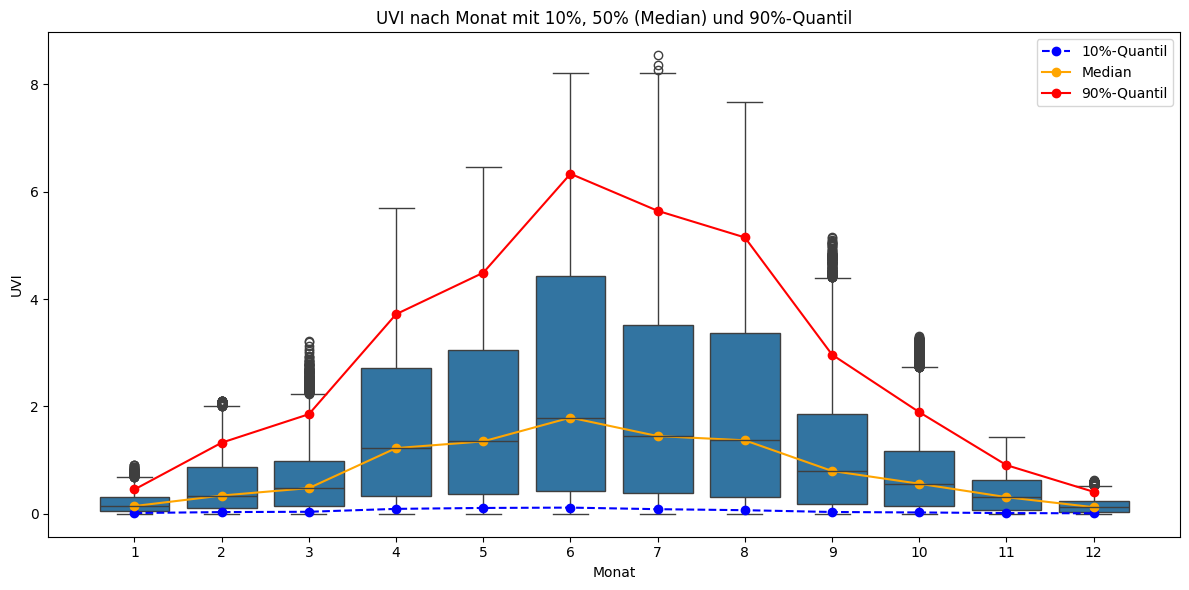

In [37]:
# Stelle sicher, dass 'Monat' numerisch ist
df_Messwerte['Monat'] = df_Messwerte['Monat'].astype(int)

# Berechnung der Quantile und Median pro Monat
uvi_quantiles = df_Messwerte.groupby('Monat')['UVI'].quantile([0.1, 0.5, 0.9]).unstack()

plt.figure(figsize=(12, 6))

# Boxplot
sns.boxplot(data=df_Messwerte, x='Monat', y='UVI')

# Liniendiagramme für Quantile
plt.plot(uvi_quantiles.index - 1, uvi_quantiles[0.1], label='10%-Quantil', color='blue', linestyle='dashed', marker='o')
plt.plot(uvi_quantiles.index - 1, uvi_quantiles[0.5], label='Median', color='orange', linestyle='solid', marker='o')
plt.plot(uvi_quantiles.index - 1, uvi_quantiles[0.9], label='90%-Quantil', color='red', linestyle='solid', marker='o')

# Plot-Details
plt.title('UVI nach Monat mit 10%, 50% (Median) und 90%-Quantil')
plt.xlabel('Monat')
plt.ylabel('UVI')
plt.legend()
plt.tight_layout()
plt.show()

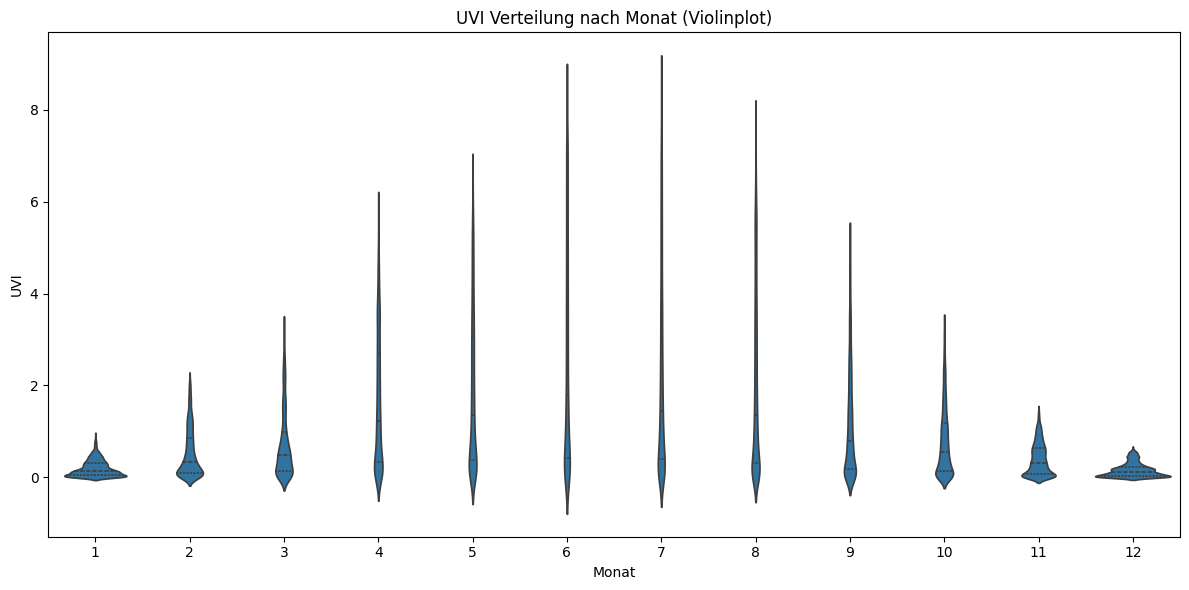

In [24]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_Messwerte, x='Monat', y='UVI', inner='quartile')
plt.title('UVI Verteilung nach Monat (Violinplot)')
plt.tight_layout()
plt.show()

In [31]:
df_Messwerte['Cloud_Index'] = df_Messwerte['ghi'] / df_Messwerte['Clear_sky_GHI']
# z. B. in Klassen einteilen
df_Messwerte['Bewölkung'] = pd.cut(df_Messwerte['Cloud_Index'],
                                   bins=[0, 0.2, 0.5, 0.8, 1.0, 1.5],
                                   labels=['sehr bewölkt', 'bewölkt', 'teilweise', 'klar', 'überklar'])

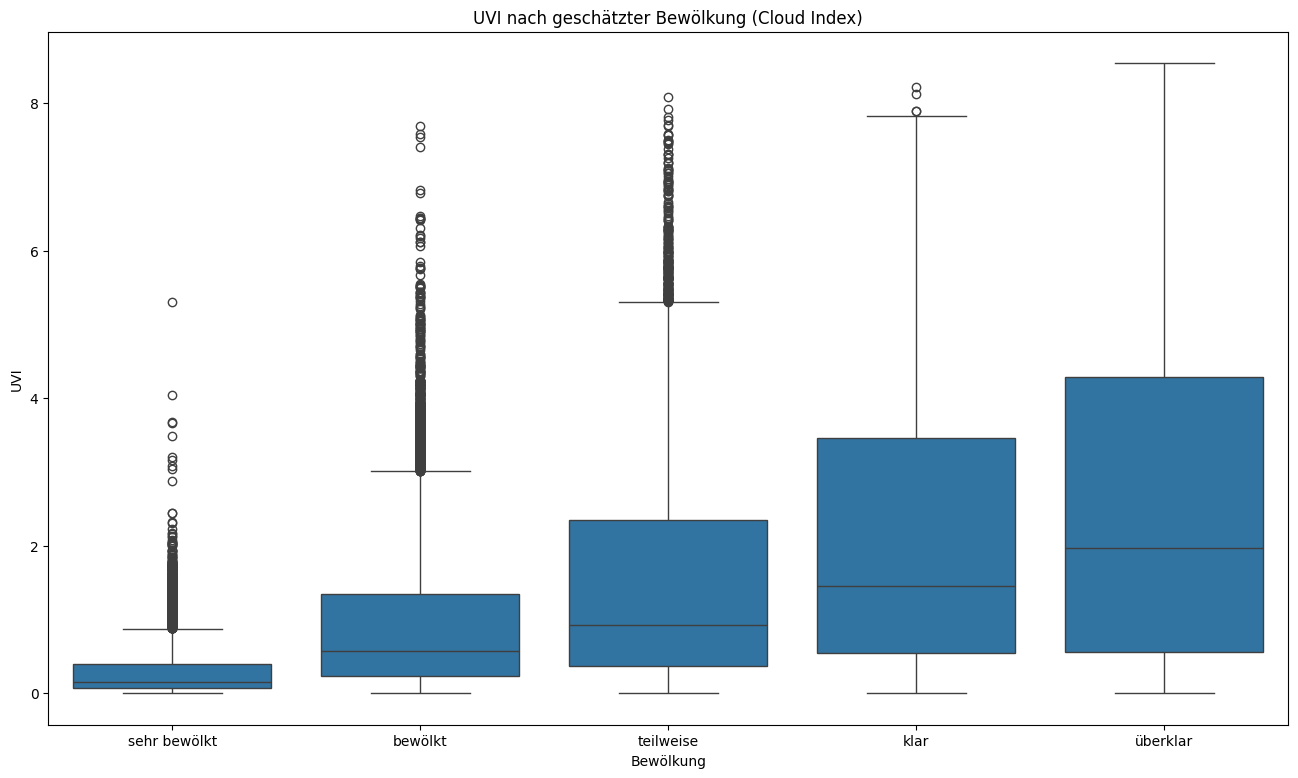

In [32]:
sns.boxplot(data=df_Messwerte, x='Bewölkung', y='UVI')
plt.title('UVI nach geschätzter Bewölkung (Cloud Index)')
plt.show()

In [26]:
quantiles = df_Messwerte.groupby('Time_bins')['UVI'].quantile([0.1, 0.5, 0.9]).unstack()
quantiles.columns = ['10%', '50%', '90%']
print(quantiles)

                  10%       50%       90%
Time_bins                                
03:00-06:00  0.003987  0.065393  0.342117
06:00-09:00  0.013827  0.457537  2.331358
09:00-12:00  0.230810  1.557163  5.526527
12:00-15:00  0.133201  1.114642  4.917400
15:00-18:00  0.027487  0.354794  1.688805
18:00-21:00  0.030844  0.091878  0.213836


/tmp/ipython-input-2646698900.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df_Messwerte.groupby('Time_bins')['UVI'].quantile([0.1, 0.5, 0.9]).unstack()


/tmp/ipython-input-57453667.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_90 = df_Messwerte.pivot_table(
/tmp/ipython-input-57453667.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_50 = df_Messwerte.pivot_table(


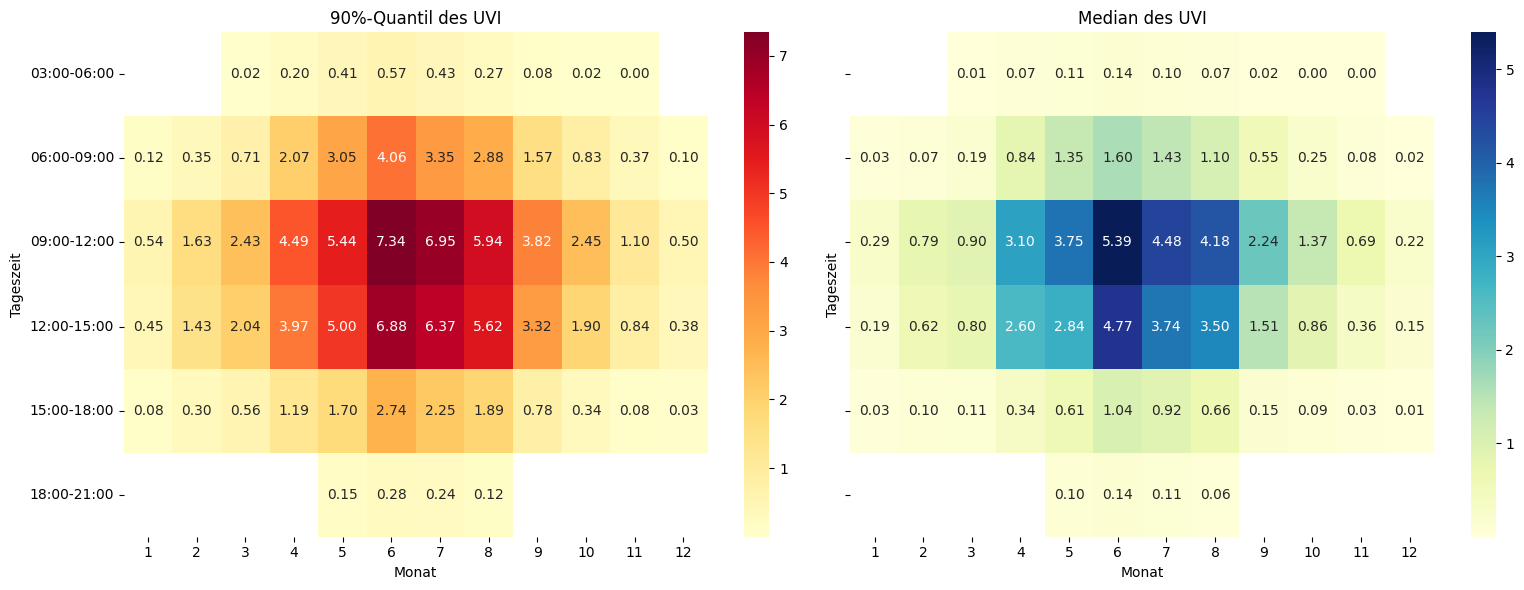

In [39]:
# Heatmap 1: 90%-Quantil
pivot_90 = df_Messwerte.pivot_table(
    index='Time_bins',
    columns='Monat',
    values='UVI',
    aggfunc=lambda x: x.quantile(0.9)
)

# Heatmap 2: Median (50%-Quantil)
pivot_50 = df_Messwerte.pivot_table(
    index='Time_bins',
    columns='Monat',
    values='UVI',
    aggfunc='median'  # oder: lambda x: x.quantile(0.5)
)

# Plot: zwei Heatmaps nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Heatmap für 90%-Quantil
sns.heatmap(pivot_90, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[0])
axes[0].set_title("90%-Quantil des UVI")
axes[0].set_ylabel("Tageszeit")
axes[0].set_xlabel("Monat")

# Heatmap für Median
sns.heatmap(pivot_50, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[1])
axes[1].set_title("Median des UVI")
axes[1.].set_ylabel("Tageszeit")
axes[1].set_xlabel("Monat")

plt.tight_layout()
plt.show()